In [ ]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/"
SAMPLE_RATE = 16000

# Extract Feature

In [ ]:
def extract_feature(file_name, mfcc, chroma, mel):
  with soundfile.SoundFile(file_name) as sound_file:
    X = sound_file.read(dtype="float32")
    sample_rate=sound_file.samplerate
    if chroma:
      stft=np.abs(librosa.stft(X))
    result=np.array([])
    if mfcc:
      mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
      result=np.hstack((result, mfccs))
    if chroma:
      chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
      result=np.hstack((result, chroma))
    if mel:
      mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
      result=np.hstack((result, mel))
  return result

# Define Dictionary

In [ ]:
emotions = {
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

observed_emotions = ['calm', 'happy', 'fearful', 'disgust']

# Load Dataset

In [ ]:
def load_data(test_size=0.2):
    x, y = [], []
    for root, dirs, files in os.walk(DATASET_PATH):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                file_name = os.path.basename(file_path)
                emotion = emotions[file_name.split("-")[2]]
                if emotion not in observed_emotions:
                    continue
                feature = extract_feature(file_path, mfcc=True, chroma=True, mel=True)
                x.append(feature)
                y.append(emotion)

    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

# Split dataset into training and testing set

In [ ]:
x_train,x_test,y_train,y_test= load_data(test_size = 0.25)

Observe shape

In [ ]:
print((x_train.shape[0], x_test.shape[0]))

(576, 192)


get the number of features extracted

In [ ]:
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


# Initialize model (MLPClassifier)

In [ ]:
model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

Train model

In [ ]:
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

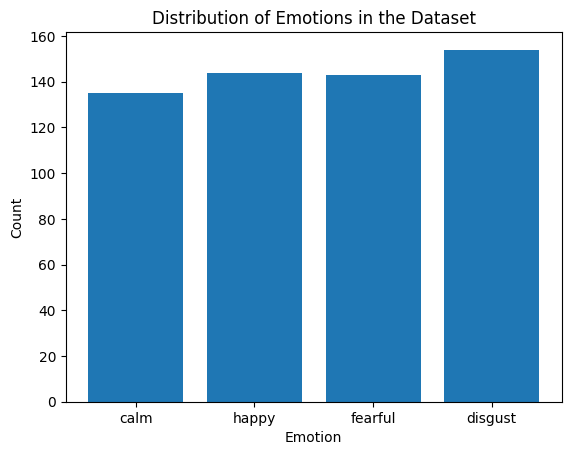

In [ ]:
import matplotlib.pyplot as plt
# Calculate the distribution of each emotion in the dataset
emotion_counts = {emotion: y_train.count(emotion) for emotion in observed_emotions}

# Plot the distribution
plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions in the Dataset')
plt.show()

Predict test set

In [ ]:
y_pred = model.predict(x_test)

# Evaluation

In [ ]:
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

print(classification_report(y_test, y_pred))

Accuracy: 70.31%
              precision    recall  f1-score   support

        calm       0.77      0.86      0.81        57
     disgust       0.76      0.58      0.66        38
     fearful       0.72      0.59      0.65        49
       happy       0.59      0.73      0.65        48

    accuracy                           0.70       192
   macro avg       0.71      0.69      0.69       192
weighted avg       0.71      0.70      0.70       192



[[49  1  2  5]
 [ 5 22  5  6]
 [ 5  2 29 13]
 [ 5  4  4 35]]


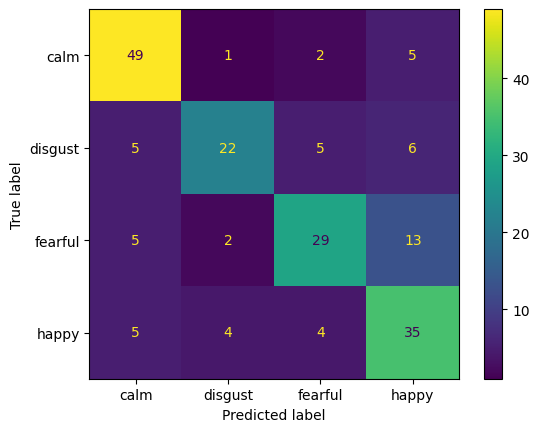

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model.classes_)
disp.plot()